In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy import sparse
import anndata
import seaborn as sns
import scvelo as scv
#import multivelo as mv

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.facecolor': 'white'})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

matplotlib.rcParams['ytick.labelright'] = False
matplotlib.rcParams['ytick.labelleft'] = True
matplotlib.rcParams['ytick.right'] = False
matplotlib.rcParams['ytick.left'] = True

In [3]:
import sys
sys.path.append("../src/")
import MoFlow as mf

In [4]:
multivelo = anndata.read_h5ad(
    '../data/Mouse_brain/multivelo_result.h5ad')
celldancer = anndata.read_h5ad(
    '../data/Mouse_brain/celldancer.h5ad')

In [5]:
adata_out = anndata.read_h5ad(
    '../data/Mouse_brain/adata_out.moflow.mvstyle.h5ad')

In [6]:
#labels = pd.read_csv('../temps/250222_mousebrain_cluster.csv', index_col=0)
labels = pd.read_csv('../temps/250325_mousebrain_cluster.csv', index_col=0)

computing velocity embedding
    finished (0:00:00) --> added
    'velo_s_umap', embedded velocity vectors (adata.obsm)
saving figure to file ../figures/fig6A_mosync.svg


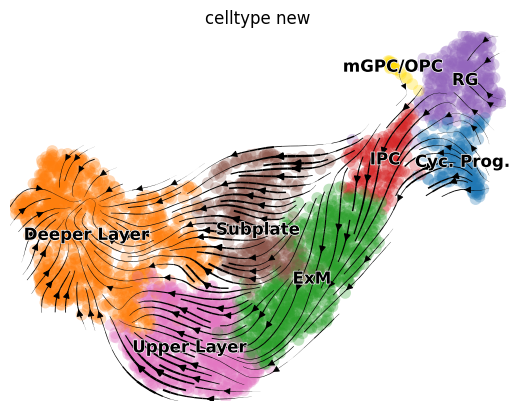

In [ ]:
scv.pl.velocity_embedding_stream(adata_out,
                                 vkey='velo_s',
                                 color='celltype_new',
                                 save='../figures/fig6A_moflow.svg')

saving figure to file ../figures/fig6A_time.pdf


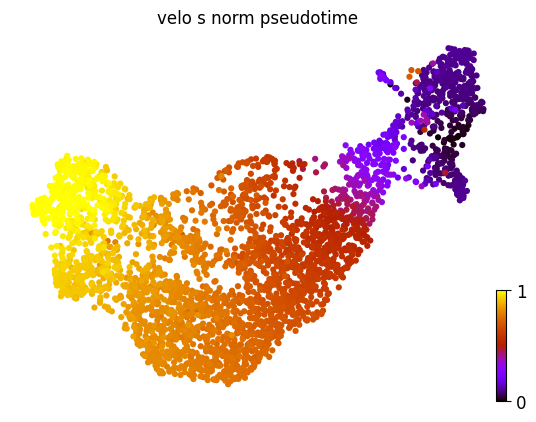

In [18]:
scv.pl.scatter(adata_out, color='velo_s_norm_pseudotime',
               cmap='gnuplot', size=80,
save='../figures/fig6A_time.pdf')

saving figure to file ../figures/fig6A_multivelo.svg


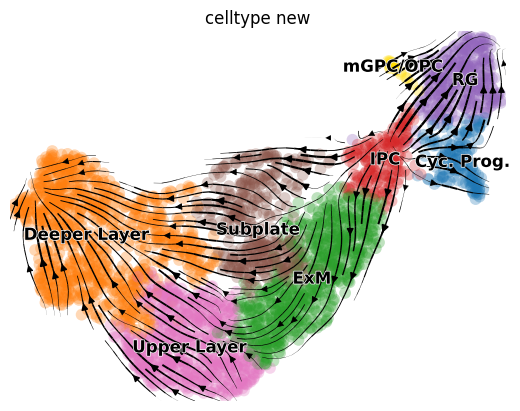

In [19]:
scv.pl.velocity_embedding_stream(multivelo,
                                 vkey='velo_s_norm',
                                 color='celltype_new',
                                 save='../figures/fig6A_multivelo.svg')

saving figure to file ../figures/fig6A_celldancer.svg


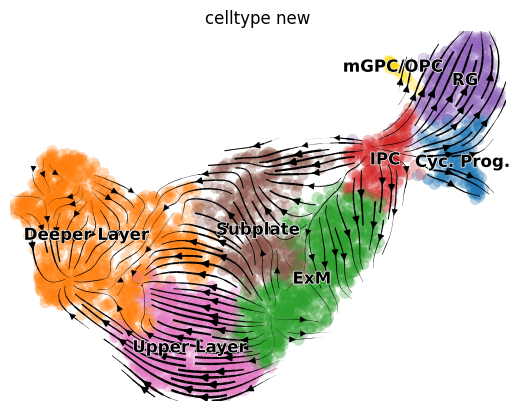

In [20]:
scv.pl.velocity_embedding_stream(celldancer,
                                 vkey='velo_s',
                                 color='celltype_new',
                                 save='../figures/fig6A_celldancer.svg')

In [7]:
marker_genes_dict ={
    'Cyc. Prog.' : ['Top2a', 'Clspn', 'Aurka', 'Mki67'],  

    # **Radial Glia (RG)**
    'RG' : ['Atp1a2', 'Vim', 
    'Fgfr3', 'Fabp7', #early RG
    'Cd9', 'Tnc', 'Slc1a3',  # late RG
    # **Outer Radial Glia (oRG)**
    'Moxd1', 'Hopx', 'Mt3', 'Tnc', ],

    # **mGPC (Multipotent Glial Progenitor Cells)**
    'mGPC/OPC': ['Ascl1', 'Olig2', 'Pdgfra', 'Egfr', 'Cspg4'], 
    
    'IPC': ['Eomes', 'Pax6'], #IPC
    #['Eomes', 'Dcx', 'Tubb3', 'Pax6']
    'ExM': ['Dcx', 'Tubb3', ],
    
    # **Subplate Neurons**
    'Subplate' : ['Nr4a2', 'Crym', 'Ldb2', 'Sox5', 'Tbr1'], 

    # **Glutamatergic Neurons**
    'Upper Layer': ['Satb2', 'Rorb', 'Cux1', 'Cux2', 'Tle4'], #upper layer
    'Deeper Layer' : ['Bcl11b', 'Fezf2',  'Foxp2', 'Tbr1'], #deeper layer

    
}

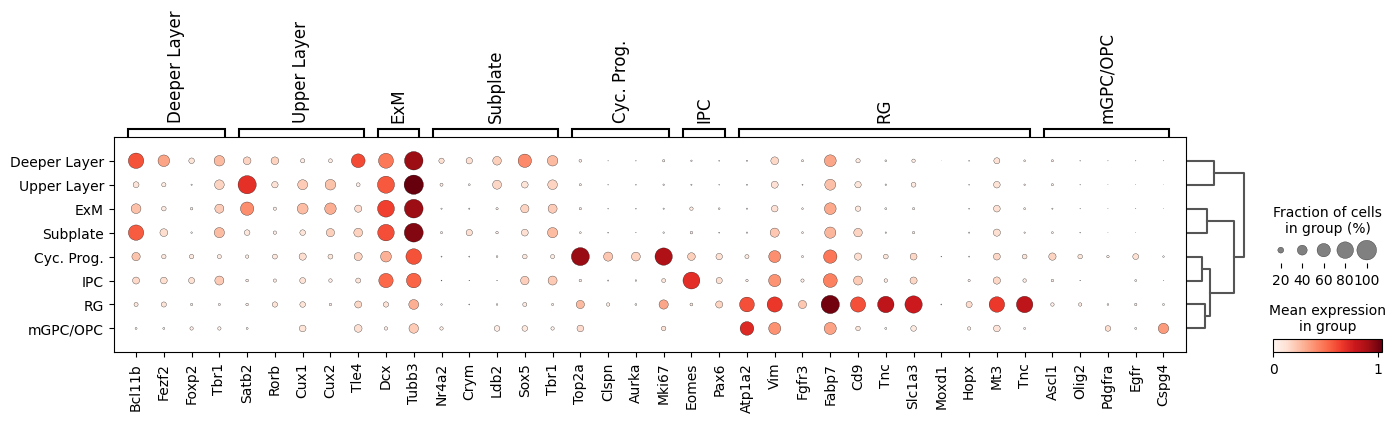

In [13]:
import scanpy as sc
dp = sc.pl.dotplot(adata_out, marker_genes_dict, "celltype_new", dendrogram=True, return_fig=True)
dp.savefig('../figures/fig6A_S_dot.pdf')


In [6]:
cluster_edges = (('Cyc. Prog.', 'RG'), ('Cyc. Prog.', 'IPC'), ('RG', 'IPC'),('RG', 'mGPC/OPC'),
 ('IPC',' Subplate'), ('IPC', 'ExM'),
 ('Subplate', 'Deeper Layer'),  ('Subplate', 'Upper Layer'),
 ('ExM', 'Subplate'), ('ExM', 'Deeper Layer'),('ExM', 'Upper Layer'))

In [8]:
scv.pp.neighbors(celldancer, method='sklearn')
scv.pp.neighbors(multivelo, method='sklearn')
scv.pp.neighbors(adata_out, method='sklearn')

computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [7]:
cbdir = {}
cbdir['mosync'] = mf.cross_boundary_correctness(adata_out, 'celltype_new', 'velo_s', cluster_edges,
                                          True, 'X_umap')
cbdir['celldancer'] = mf.cross_boundary_correctness(celldancer, 'celltype_new', 'velo_s', cluster_edges,
                                          True, 'X_umap')
cbdir['multivelo'] = mf.cross_boundary_correctness(multivelo, 'celltype_new', 'velo_s_norm', cluster_edges,
                                          True, 'X_umap')

In [8]:
cbdir_ = []
for k in cbdir.values():
    temp = {}
    for c, s in k.items():
        s = np.mean(s)
        temp[c] = s
    cbdir_.append(temp)
    
cbdir_ = pd.DataFrame(cbdir_, index=cbdir.keys())

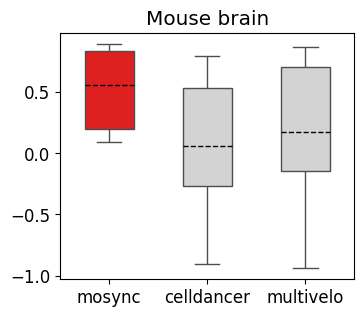

In [11]:
fig, ax = plt.subplots(figsize=(3.2, 3.2), )
sns.boxplot(cbdir_.T, palette=['red', 'lightgrey', 'lightgrey'], medianprops=dict(linewidth=0),
            meanline=True, showmeans=True, width=.5, meanprops=dict(color='black'))
ax.set_title('Mouse brain')

fig.savefig('../figures/fig5B_cbdir')

In [16]:
print(cbdir_.mean(axis=1), '\n',
      cbdir_.std(axis=1))

mosync        0.553265
celldancer    0.059915
multivelo     0.174090
dtype: float64 
 mosync        0.337397
celldancer    0.601298
multivelo     0.672722
dtype: float64


In [14]:
from sklearn.cluster import KMeans

In [15]:
kmeans = KMeans(n_clusters=18)
kmeans.fit(adata_out.layers['s'].T)

KMeans(n_clusters=18)

In [26]:
labels = pd.DataFrame(kmeans.labels_, index=adata_out.var_names, columns=['label'])

In [38]:
labeldict={0: 10,
           1: 3,
           2: 2,
           3: 9,
           4: 0,
           5: 11,
           6: 5,
           7: 1,
           8: 3,
           9: 7,
           10: 8,
           11: 1,
           12: 9,
           13: 4,
           14: 1,
           15: 6,
           16: 1,
           17: 5,
               
}

In [45]:
labels_ = labels.copy()
labels_['label'] = labels_['label'].map(labeldict)

In [61]:
labels_.to_csv('../temps/250325_mousebrain_cluster.csv')

In [14]:
labels = pd.read_csv('../temps/250325_mousebrain_cluster.csv',
                     index_col=0)

In [21]:
scv.tl.score_genes_cell_cycle(adata_out)

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


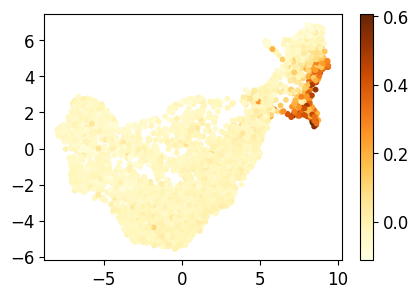

In [22]:
fig, ax = plt.subplots(figsize=(4.8, 3.2))
im = plt.scatter(
    x = adata_out.obsm['X_umap'][:, 0],
    y = adata_out.obsm['X_umap'][:, 1],
    c= adata_out.obs['G2M_score'].ravel(),
    cmap='YlOrBr', s=10
    )
plt.colorbar(im)
fig.savefig('../figures/fig6A_g2m.pdf')

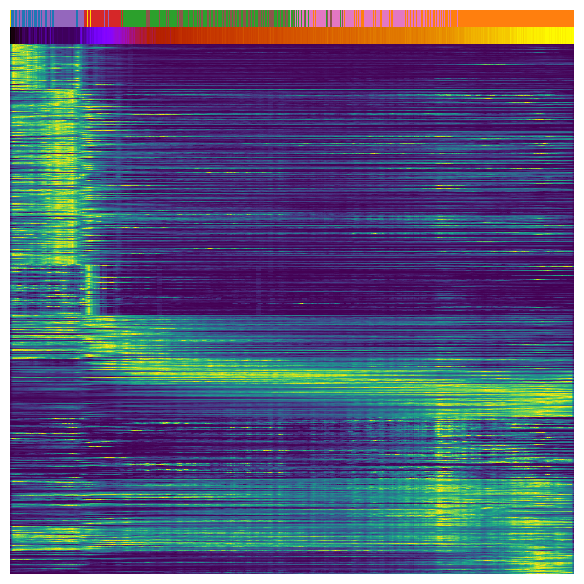

In [16]:
g = scv.pl.heatmap(adata_out,
               var_names=labels.sort_values(by='label').index,
               sort=False,
               sortby='velo_s_norm_pseudotime',
               color_map='viridis',
               col_color=['celltype_new', 'velo_s_pseudotime'],
               palette='gnuplot',
                yticklabels=False,
                figsize=(6,6),
                #save='../figures/fig2E.heatmap.pdf',
                dpi=150)

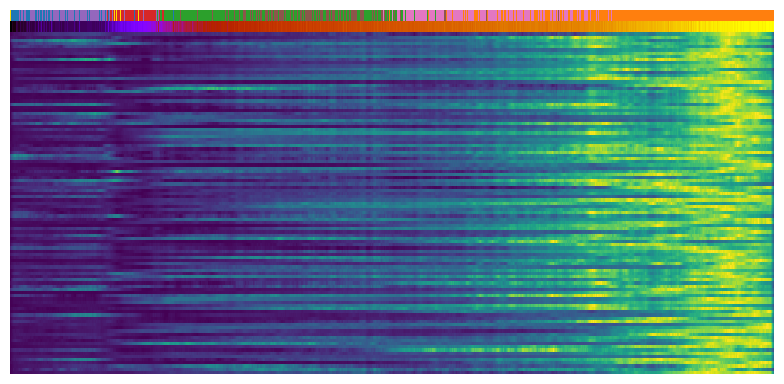

In [10]:
g = scv.pl.heatmap(adata_out,
               var_names=labels[labels['label'].isin([7])].index,
               sort=False,
               sortby='velo_s_norm_pseudotime',
         color_map='viridis',
               col_color=['celltype_new', 'velo_s_pseudotime'],
               palette='gnuplot',
                yticklabels=False,)

In [24]:
model = np.zeros(adata_out.n_vars).astype(str)
on_ = np.zeros(adata_out.n_vars)
off_ = np.zeros(adata_out.n_vars)
m1_ = np.zeros(adata_out.n_vars)
m2_ = np.zeros(adata_out.n_vars)

for i, g in enumerate(adata_out.var_names):
    c = adata_out[:, g].layers['c'].ravel()
    u = adata_out[:, g].layers['u'].ravel()
    s = adata_out[:, g].layers['s'].ravel()
    
    vc = adata_out[:, g].layers['velo_c'].ravel()
    vs = adata_out[:, g].layers['velo_s'].ravel()
    vu = adata_out[:, g].layers['velo_u'].ravel()
    
    w_non_zero = ((c >= 0.1 * np.max(c)) &
                    (u >= 0.1 * np.max(u)) &
                    (s >= 0.1 * np.max(s)))
    u_non_zero = u[w_non_zero]
    s_non_zero = s[w_non_zero]
    wu = u >= np.percentile(u_non_zero, 90)
    ws = s >= np.percentile(s_non_zero, 90)
    
    #ww = wu|ws&down
    ww = wu|ws
    ww |= (vu * vs >= 0)
    
    on_[i] = np.mean((vu[w_non_zero]>0)&(vs[w_non_zero]>0))
    off_[i] = np.mean((vu[w_non_zero]<0)&(vs[w_non_zero]<0))
    m1_[i] = np.mean((vc[ww]<0)&(vu[ww]>0))
    m2_[i] = np.mean((vc[ww]>0)&(vu[ww]<0))
    #m1_[i] = np.mean((vc[ww]<0))
    #m2_[i] = np.mean((vc[ww]>=0))

In [25]:
temp = pd.DataFrame({'on': on_, 'off': off_,
                     'm1': m1_, 'm2': m2_},
                    index=adata_out.var_names)

In [26]:
temp['label'] = labels['label']

In [27]:
genelist = set(adata_out.var_names) & set(multivelo.var_names)
adata_out_ = adata_out[:, adata_out.var_names.isin(genelist)]
multivelo_ = multivelo[:, multivelo.var_names.isin(genelist)]
temp_ = temp.loc[ multivelo_.var_names.values]

In [28]:
temp_['fit_model'] = multivelo_.var['fit_model']
temp_['fit_direction'] = multivelo_.var['fit_direction']

In [29]:
temp['m1'] = temp['m1']/(temp['m1'] + temp['m2'])
temp['m2'] = temp['m2']/(temp['m1'] + temp['m2'])

In [30]:
from scipy import stats

In [31]:
stats.ttest_ind(temp_[temp_['fit_model']==1]['m1'], temp_[temp_['fit_model']==2]['m1'],
                equal_var=False, alternative='greater')

TtestResult(statistic=4.215767484387448, pvalue=1.3898128392683568e-05, df=783.2971622886959)

In [32]:
stats.ttest_ind(temp_[temp_['fit_model']==1]['m2'], temp_[temp_['fit_model']==2]['m2'],
                equal_var=False, alternative='less')

TtestResult(statistic=-9.203115217386928, pvalue=2.250533167424279e-19, df=661.2465284743807)

In [33]:
stats.ttest_ind(temp_[temp_['fit_model']==1]['off'], temp_[temp_['fit_model']==2]['off'],
                equal_var=False, alternative='less')

TtestResult(statistic=-15.372553030121265, pvalue=9.086842925577195e-46, df=624.7757722867838)

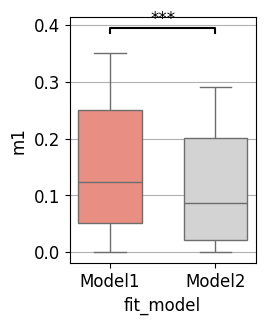

In [35]:
fig, ax = plt.subplots(figsize=(2.4, 3.2))
sns.boxplot(temp_, y='m1', x='fit_model',
             fill=True, palette=['salmon', 'lightgrey'],  width=.6, whis=.5, showfliers=False)
ax.grid(axis='y')

ylim = ax.get_ylim()
yrange = ylim[1] - ylim[0]
h = 0.02*yrange
offset = 0.05 * yrange
y = ylim[1] + offset
x1, x2 = 0, 1
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
ax.text((x1+x2)/2, y+h*2, '***', ha='center')

ax.set_xticklabels(['Model1', 'Model2'])

fig.savefig('../figures/fig6D_mvmodel_m1.pdf')

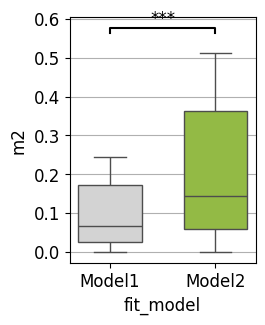

In [36]:
fig, ax = plt.subplots(figsize=(2.4, 3.2))
sns.boxplot(temp_, y='m2', x='fit_model',
             fill=True, palette=['lightgrey', 'yellowgreen'],  width=.6, whis=.5, showfliers=False)
ax.grid(axis='y')
ax.set_xticklabels(['Model1', 'Model2'])

ylim = ax.get_ylim()
yrange = ylim[1] - ylim[0]
h = 0.02*yrange
offset = 0.05 * yrange
y = ylim[1] + offset
x1, x2 = 0, 1
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
ax.text((x1+x2)/2, y+h*2, '***', ha='center')

ax.set_xticklabels(['Model1', 'Model2'])

fig.savefig('../figures/fig6D_mvmodel_m2.pdf')

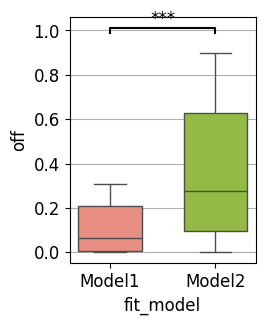

In [37]:
fig, ax = plt.subplots(figsize=(2.4, 3.2))
sns.boxplot(temp_, y='off', x='fit_model',
             fill=True, palette=['salmon', 'yellowgreen'], width=.6, whis=.5, showfliers=False)
ax.grid(axis='y')
ax.set_xticklabels(['Model1', 'Model2'])

ylim = ax.get_ylim()
yrange = ylim[1] - ylim[0]
h = 0.02*yrange
offset = 0.05 * yrange
y = ylim[1] + offset
x1, x2 = 0, 1
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
ax.text((x1+x2)/2, y+h*2, '***', ha='center')

ax.set_xticklabels(['Model1', 'Model2'])

fig.savefig('../figures/fig6D_mvmodel_off.pdf')

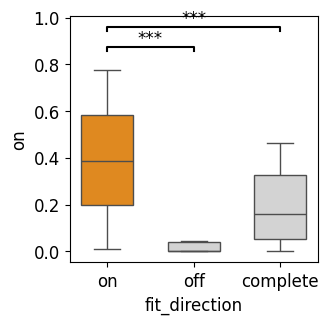

In [38]:
fig, ax = plt.subplots(figsize=(3.2, 3.2))
sns.boxplot(temp_, y='on', x='fit_direction',
             fill=True, palette=['darkorange', 'lightgrey', 'lightgrey'], 
             order=['on', 'off', 'complete'], width=.6, whis=.5, showfliers=False)
ax.grid(axis='y')

ylim = ax.get_ylim()
yrange = ylim[1] - ylim[0]
h = 0.02*yrange
offset = 0.05 * yrange
y = ylim[1] + offset
x1, x2 = 0, 1
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
ax.text((x1+x2)/2, y+h*2, '***', ha='center')

x1, x2 = 0, 2
y = y+h*5
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
ax.text((x1+x2)/2, y+h*2, '***', ha='center')


ax.grid(axis='y')
fig.savefig('../figures/fig6D_S_mvmodel_diron.pdf')

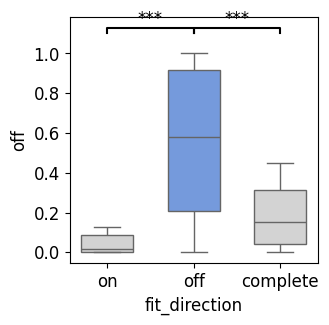

In [39]:
fig, ax = plt.subplots(figsize=(3.2, 3.2))
sns.boxplot(temp_, y='off', x='fit_direction',
             fill=True, palette=['lightgrey', 'cornflowerblue', 'lightgrey'], 
             order=['on', 'off', 'complete'], width=.6, whis=.5, showfliers=False)
ax.grid(axis='y')

ylim = ax.get_ylim()
yrange = ylim[1] - ylim[0]
h = 0.02*yrange
offset = 0.05 * yrange
y = ylim[1] + offset
x1, x2 = 0, 1
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
ax.text((x1+x2)/2, y+h*2, '***', ha='center')

x1, x2 = 1, 2
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
ax.text((x1+x2)/2, y+h*2, '***', ha='center')



ax.grid(axis='y')
fig.savefig('../figures/fig6D_S_mvmodel_diroff.pdf')

In [40]:
goterm = []
for i in range(12):
    gobp = pd.read_csv(f'../temps/mb_cluster{i}.txt', sep='\t')
    gobp['cluster'] = i
    goterm.append(gobp.head(10))


In [41]:
goterm_ = pd.concat(goterm)

In [42]:
shortterm = []
for t in goterm_['Term']:
    if 'cell division' in t:
        shortterm.append('Cell division')
    elif 'cell cycle' in t:
        shortterm.append('Cell division')
    elif 'proliferation' in t:
        shortterm.append('Proliferation')
    elif 'migration' in t:
        shortterm.append('Migration')
    elif ('chromosome segregation' in t) or ('chromatin organization' in t) or ('regeneration' in t):
        shortterm.append('Cell division')
    elif 'DNA repair' in t:
        shortterm.append('DNA repair')
    elif 'DNA damage' in t:
        shortterm.append('DNA repair')
    elif ('mitotic' in t) or ('mitosis' in t):
        shortterm.append('Mitosis')
    
    elif (('response' in t ) & ('stress' in t)) or ('hypoxia' in t) or ('mechanical stimulus' in t) or ('response to metal ion' in t) or ('apoptotic' in t):
        shortterm.append('Response to stimulus')
    elif ('metabolic' in t):
        shortterm.append('Cell environment')
    elif ('signal transduction') in t or ('pathway' in t) or ('cascade' in t):
        shortterm.append('Signal transduction') 
    elif ('angiogenesis' in t) or ('blood vessel' in t):
        shortterm.append('Development')
    elif ('synapse' in t ) or ('synaptic' in t):
        if ('organization' in t ) or ('assembly' in t):
            shortterm.append('Neural & synaptic function')
        elif ('translation' in t) or ('protein localization' in t):
            shortterm.append('Neural & synaptic function')
        elif ('potentiation' in t) or ('transmission' in t) or ('potential' in t) or ('long-term synaptic depression' in t):
            shortterm.append('Neural & synaptic function')        
    
    elif ('development' in t) or ('animal organ morphogenesis' in t) or ('stem cell' in t):
        shortterm.append('Development')
    elif ('memory' in t) or ('visual' in t):
        shortterm.append('Neural & synaptic function')
    elif 'axon' in t:
        shortterm.append('Axon development')
    elif ('behavior' in t) or ('startle' in t) or ('GO:0050885~neuromuscular process controlling balance' in t):
        shortterm.append('Neural & synaptic function')
    elif ('dichotomous subdivision of terminal units involved in salivary gland branching' in t):
        shortterm.append('Development')
    elif ('dorsal/ventral pattern formation' in t):
        shortterm.append('Cell division')
    elif 'neuronal action potential' in t:
        shortterm.append('Neural & synaptic function')     
    elif ('cell adhesion' in t) or ('extracellular matrix' in t):
        shortterm.append('Cell environment')     
    elif 'transcription' in t:
        shortterm.append('Gene expression & processing')
    elif (('processing' in t) & ('RNA' in t)) | ('transport' in t) | ('splicing' in t) | ('export' in t):
        shortterm.append('Gene expression & processing')
    elif ('translation' in t) or ('ribosomal' in t) or ('proteolysis' in t) or ('protein' in t):
        shortterm.append('Gene expression & processing')
    elif ('microtubule' in t) or ('vesicle fusion' in t):
        shortterm.append('Cell environment')  
    elif 'pain' in t:
        shortterm.append('Response to stimulus')  
        
    else:
        shortterm.append(t.split('~')[1])
        #print(t)

In [43]:
goterm_['short term'] = shortterm

In [44]:
pivot  = pd.pivot_table(goterm_, index='short term', columns='cluster', values='PValue', aggfunc='min').fillna(1)

In [45]:
pivot = -np.log10(pivot)

In [46]:
pivot = pivot.drop(['biological_process', 'cardiac conduction', 'glial cell fate specification'],axis=0)

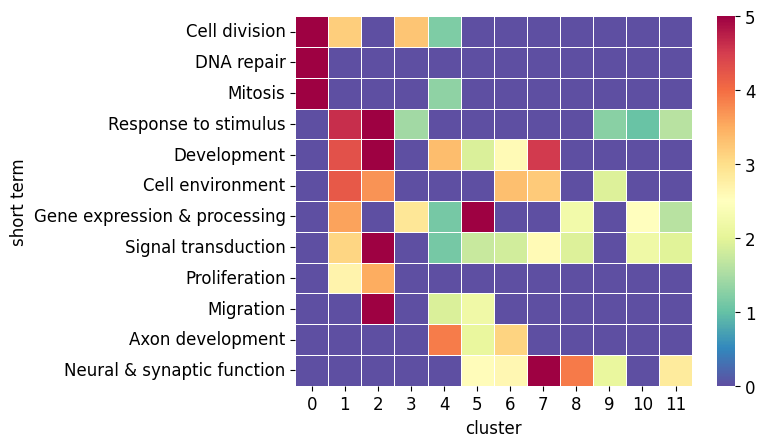

In [49]:
sns.heatmap(pivot.sort_values(by=list(range(12)), ascending=False),
            cmap="Spectral_r", vmax=5, linewidth=.5)
plt.savefig('../figures/fig6G_GO.pdf')

In [6]:
import scanpy as sc

In [7]:
adata_norma = adata_out.copy()
adata_norma.layers['alpha'] -= adata_norma.layers['alpha'].min(axis=0)
adata_norma.layers['alpha'] /= adata_norma.layers['alpha'].max(axis=0)


In [8]:
agg_c = sc.get.aggregate(adata_norma, by='celltype', axis=0, layer='c', func=['mean', 'var'])
agg_a = sc.get.aggregate(adata_norma, by='celltype', axis=0, layer='alpha', func=['mean', 'var'])

In [9]:
agg_df = pd.DataFrame({
          "c": np.std(agg_c.layers['mean'], axis=0),
          "a": np.std(agg_a.layers['mean'], axis=0)},
                      index=adata_out.var_names)

In [10]:
agg_df['label'] = labels['label']

In [11]:
import gseapy as gp

In [12]:
gene_sets="GO_Biological_Process_2025"

In [83]:
agg_df_upcase = agg_df.copy()
agg_df_upcase.index = np.char.upper(agg_df.index.values.astype('str'))

In [84]:
gsea_res_a = gp.prerank(
    rnk = agg_df_upcase['a'],
    gene_sets=gene_sets,
    organism="Mouse",
    outdir=None
    
    
)
gsea_res_c = gp.prerank(
    rnk = agg_df_upcase['c'],
    gene_sets=gene_sets, 
    organism="Mouse",
    outdir=None
)

2025-05-08 11:30:29,521 [WARNING] Duplicated values found in preranked stats: 1.42% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [85]:
ax = gp.dotplot(gsea_res_a.res2d, column="FDR q-val", top_term=5,
             figsize=(2.4, 2.4), title='alpha', vmax=2.9, vmin=2.8,
             ofname='../figures/fig6I_S_gsea_a.pdf'
)

In [86]:
ax = gp.dotplot(gsea_res_c.res2d, column="NOM p-val", top_term=5,
             figsize=(2.4, 2.4), title='chromatin accessibility', 
             ofname='../figures/fig6I_S_gsea_c.pdf'
)

In [101]:
gsea_res_a = gp.prerank(
    rnk = agg_df_upcase[agg_df_upcase['label']==0]['a'],
    gene_sets=gene_sets,
    organism="Mouse",
    outdir=None, 
    
)

gsea_res_c = gp.prerank(
    rnk = agg_df_upcase[agg_df_upcase['label']==0]['c'],
    gene_sets=gene_sets,
    organism="Mouse",
    outdir=None, 
    
)

2025-05-08 11:33:49,122 [WARNING] Duplicated values found in preranked stats: 0.42% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


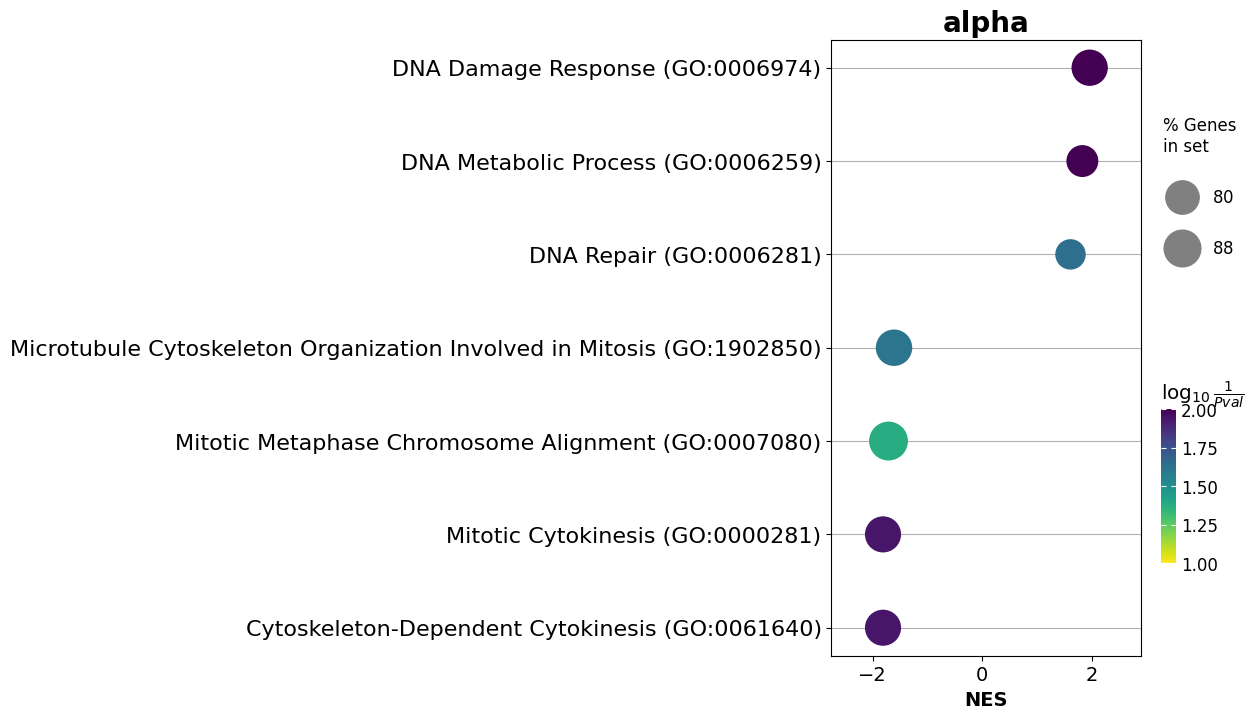

In [102]:
ax = gp.dotplot(gsea_res_a.res2d, column="NOM p-val", top_term=10,
             figsize=(5,8), title='alpha', 
             #ofname='../figures/fig6I_gsea_0a.pdf'
)

In [104]:
ax = gp.dotplot(gsea_res_c.res2d, column="NOM p-val", top_term=5,
             figsize=(2.4, 2.4), title='chromatin accessibility',
             
             ofname='../figures/fig6I_S_gsea_0c.pdf'
)

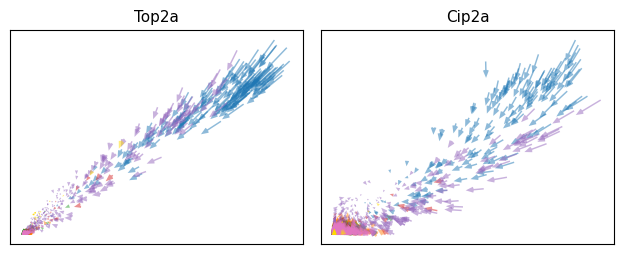

In [21]:
fig, ax = mf.scatter_gene(adata_out, 
                          ['Top2a', 'Cip2a',
                                      ],
                          color_by='celltype_new',
                          velocity_arrows=True, axis_on=False)
fig.savefig('../figures/fig6J.pdf')

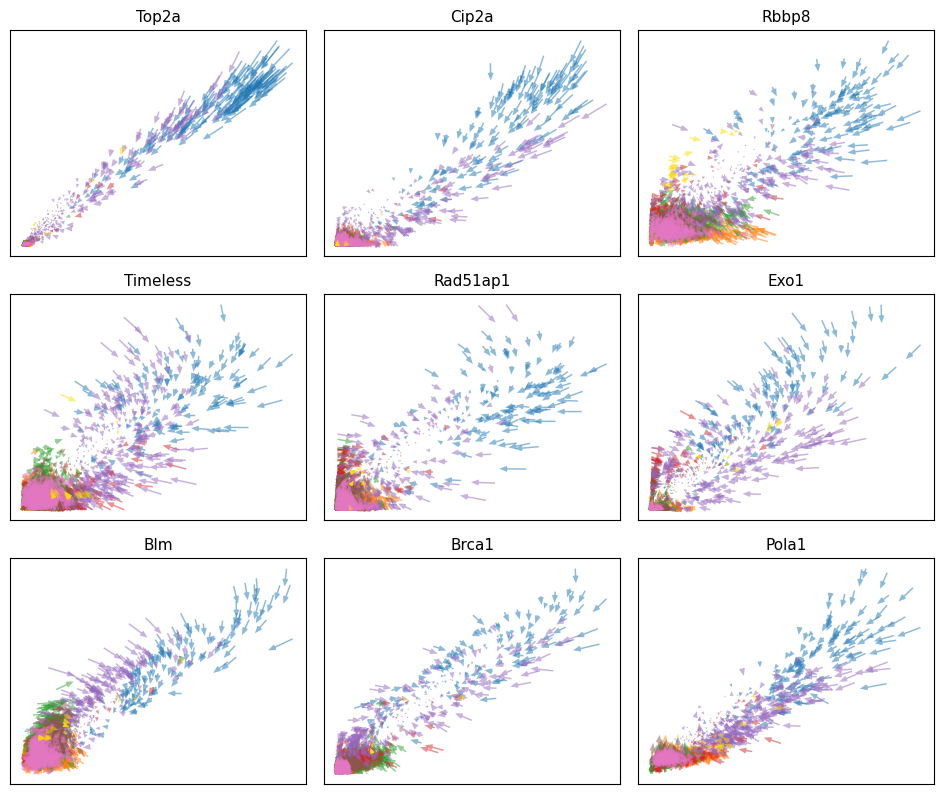

In [24]:
fig, ax = mf.scatter_gene(adata_out, 
                          ['Top2a', 'Cip2a', 'Rbbp8', 'Timeless', 'Rad51ap1', 'Exo1',
                           'Blm', 'Brca1', 'Pola1'
                                      ],
                          color_by='celltype_new', n_cols=3,
                          velocity_arrows=True, axis_on=False)
fig.savefig('../figures/fig6J_S_mf.pdf')

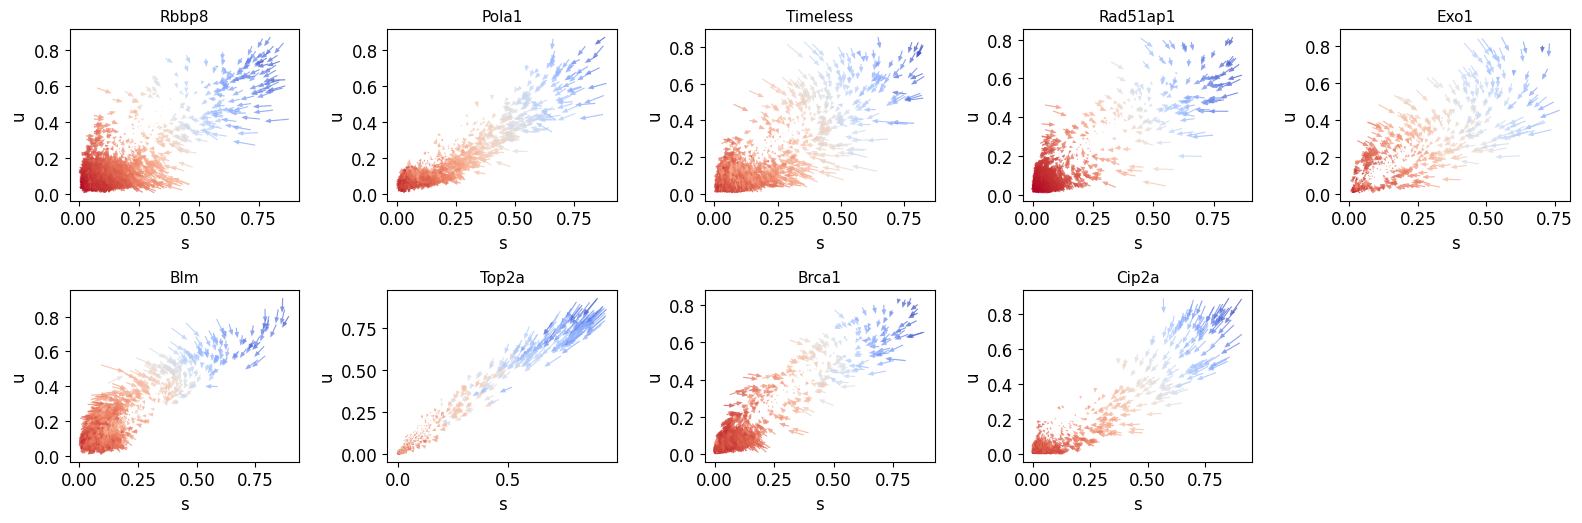

In [7]:
fig, ax = mf.scatter_gene(adata_out, 
                          ['Rbbp8', 'Pola1', 'Timeless', 'Rad51ap1', 'Exo1',
                           'Blm', 'Top2a', 'Brca1', 'Cip2a'
                                      ],
                          color_by='alpha',
                          velocity_arrows=True)

In [18]:
multivelo.layers['Mc'] = multivelo.layers['ATAC']
multivelo.layers['velo_c'] = multivelo.layers['velo_chrom']

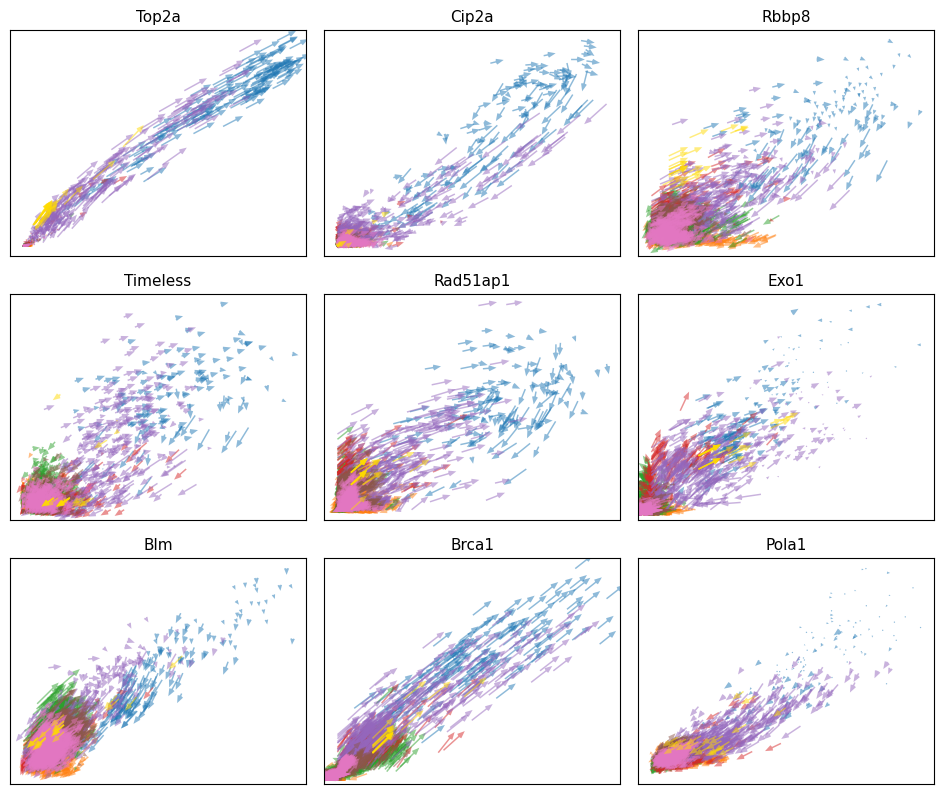

In [23]:
fig, ax = mf.scatter_gene(multivelo, 
                          ['Top2a', 'Cip2a', 'Rbbp8', 'Timeless', 'Rad51ap1', 'Exo1',
                           'Blm', 'Brca1', 'Pola1'
                                      ], n_cols=3,
                          color_by='celltype_new',
                          velocity_arrows=True, axis_on=False)
fig.savefig('../figures/fig6J_S_mv.pdf')

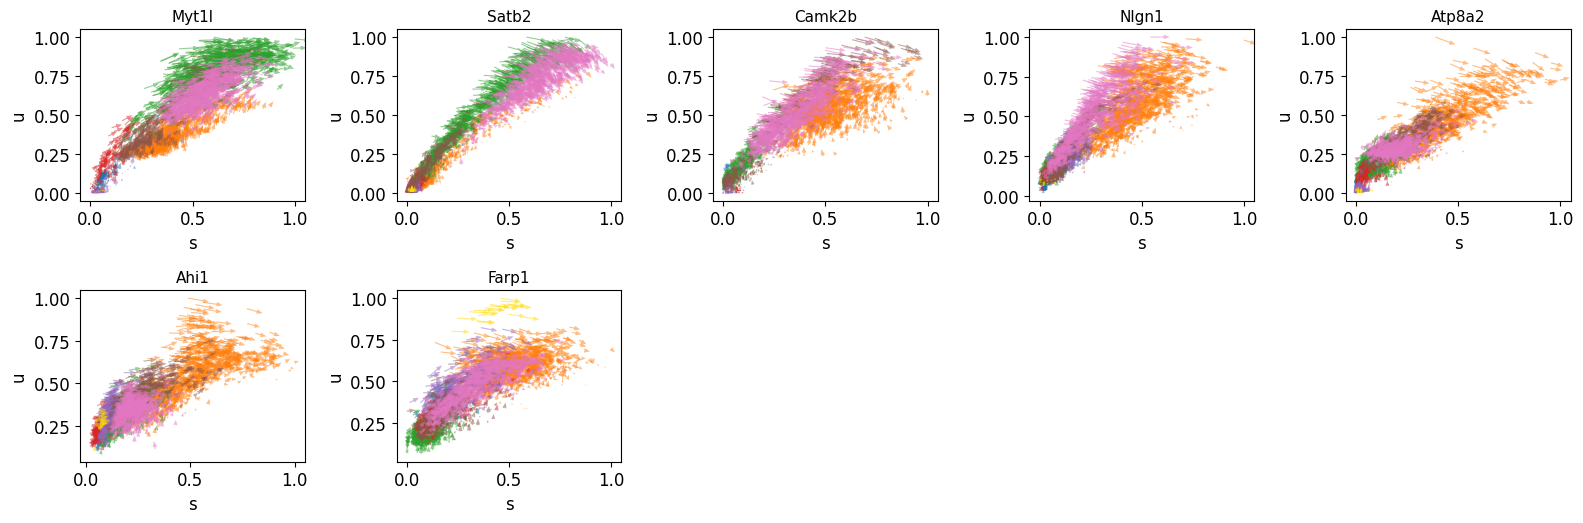

In [10]:
fig, ax = mf.scatter_gene(adata_out, 
                          ['Myt1l', 'Satb2', 'Camk2b', 'Nlgn1', 'Atp8a2',
                           'Ahi1', 'Farp1'
                                      ],
                          color_by='celltype_new',
                          velocity_arrows=True)

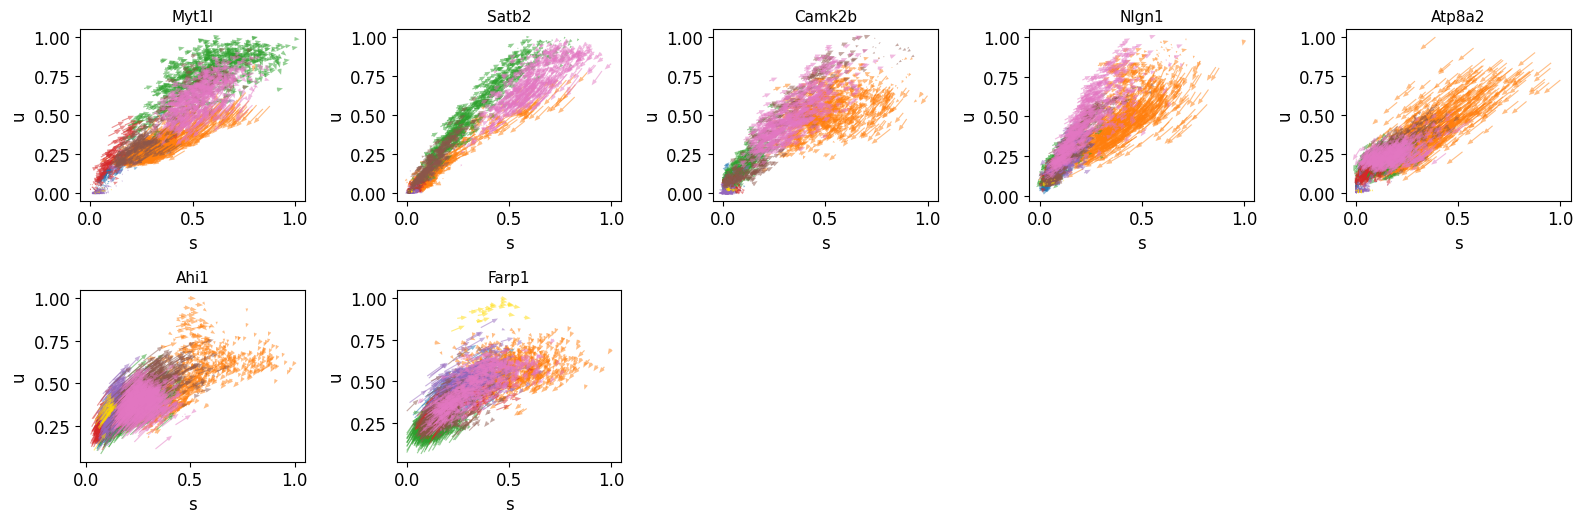

In [51]:
fig, ax = mf.scatter_gene(multivelo, 
                          ['Myt1l', 'Satb2', 'Camk2b', 'Nlgn1', 'Atp8a2',
                           'Ahi1', 'Farp1'
                                      ],
                          color_by='celltype_new',
                          velocity_arrows=True)

In [36]:
adata_out.obs['celltype_new']= pd.Categorical(adata_out.obs['celltype_new'],
                                              categories=['Cyc. Prog.','RG','IPC',  'mGPC/OPC',
                               'Subplate', 'Deeper Layer', 'ExM',  'Upper Layer'])

In [49]:
adata_out.uns['celltype_new_colors'] =\
['#1f77b4', '#9467bd', '#d62728','#ffdb00', '#8c564b','#ff7f0e', '#2ca02c', 
       '#e377c2', ]

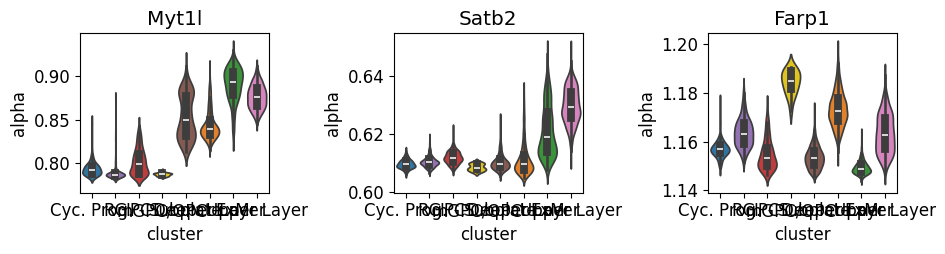

In [50]:
fig, ax = mf.gene.violinplot(adata_out,  ['Myt1l', 'Satb2', 'Farp1'
                                      ],
                        color_by='celltype_new',
                        by='alpha',
)
 

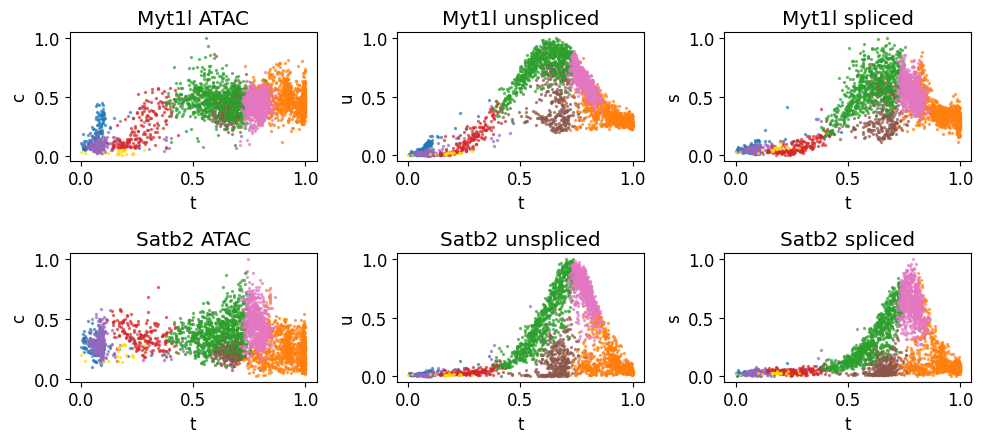

In [56]:
fig, ax = mf.dynamic_plot(adata_out,  ['Myt1l', 'Satb2'],
                          color_by='celltype_new',
                          time_key='velo_s_norm_pseudotime')

In [38]:
adata_out.uns['celltype_new_colors']

array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
       '#e377c2', '#ffdb00'], dtype=object)